# ECE 174: Mini-Project 2
## By: Jay Paek

## Set-Up

### Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

### Define Main Variables and Function

Define $e$ as Euler's constant.

In [2]:
e = np.exp(1)
e

2.718281828459045

$generate\_data\_1$ will create $n$ vectors, $\textbf{x}^{(0)},\textbf{x}^{(1)},...,\textbf{x}^{(n-1)} \in \mathbb{R}^3$ and $n$ values in $\mathbb{R}$ that fall under the following conditions defined by the problem set.
* For any pair ($\textbf{x}^{(i)}, y^{(i)}$) such that $i = 0, 1, ..., n-1$ and $\textbf{x} = \begin{bmatrix} x^{(i)}_1 & x^{(i)}_2 & x^{(i)}_3\end{bmatrix}$, $y^{(i)} =  x^{(i)}_1 x^{(i)}_2 + x^{(i)}_3$
* The values for $\textbf{max}\{x^{(i)}_1 , x^{(i)}_2 , x^{(i)}_3\} \leq \Gamma$ 
* The values for $x^{(i)}_1 , x^{(i)}_2 , x^{(i)}_3$  are randomly generated under a Gaussian distribution

In [3]:
def generate_data_1(n, gamma):
    data = np.empty((0,3))
    out = np.empty((0,1))
    for i in range(n):
        x = np.random.uniform(-gamma, gamma, (3,))
        data = np.vstack((data,x))
        out = np.append(out,[x[0]*x[1]+x[2]])
    return data, out

$d\_tanh$ will find the derivative at some point $x$ for the hyperbolic tangent function.

In [4]:
def d_tanh(x):
    return (4*e**(2*x))/((e**(2*x)+1)**2)

Define the approximator function:
$$f_{\textbf{w}}(\textbf{x}) = w_1\phi(w_2x_1 + w_3x_2 + w_4x_3 + w_5) + w_6\phi(w_7x_1 + w_8x_2 + w_9x_3 + w_{10}) + w_{11}\phi(w_{12}x_1 + w_{13}x_2 + w_{14}x_3 + w_{15}) + w_{16}$$
Where $\phi$ is $tanh$

In [5]:
def f(x, weights):
    return (weights[0]*np.tanh(weights[1]*x[0] + weights[2]*x[1] + weights[3]*x[2] + weights[4]) + 
            weights[5]*np.tanh(weights[6]*x[0] + weights[7]*x[1] + weights[8]*x[2] + weights[9]) + 
            weights[10]*np.tanh(weights[11]*x[0] + weights[12]*x[1] + weights[13]*x[2] + weights[14]) + weights[15])

$g\_tanh$ will find the gradient of $f(\text{x})$ with the gradient vector defined as the following:
$$\nabla_{\textbf{w}} = \begin{bmatrix} \frac{\partial}{\partial w_1} & \frac{\partial}{\partial w_2} & ... & \frac{\partial}{\partial w_{16}} \end{bmatrix}$$ 

In [6]:
def g_tanh(x, weights):
    return np.asarray([
        np.tanh(weights[1]*x[0] + weights[2]*x[1] + weights[3]*x[2] + weights[4]),
        weights[0]*x[0] * d_tanh(weights[1]*x[0] + weights[2]*x[1] + weights[3]*x[2] + weights[4]),
        weights[0]*x[1] * d_tanh(weights[1]*x[0] + weights[2]*x[1] + weights[3]*x[2] + weights[4]),
        weights[0]*x[2] * d_tanh(weights[1]*x[0] + weights[2]*x[1] + weights[3]*x[2] + weights[4]),
        weights[0] * d_tanh(weights[1]*x[0] + weights[2]*x[1] + weights[3]*x[2] + weights[4]),
        np.tanh(weights[6]*x[0] + weights[7]*x[0] + weights[8]*x[0] + weights[9]),
        weights[5]*x[0] * d_tanh(weights[6]*x[0] + weights[7]*x[1] + weights[8]*x[2] + weights[9]),
        weights[5]*x[1] * d_tanh(weights[6]*x[0] + weights[7]*x[1] + weights[8]*x[2] + weights[9]),
        weights[5]*x[2] * d_tanh(weights[6]*x[0] + weights[7]*x[1] + weights[8]*x[2] + weights[9]),
        weights[5] * d_tanh(weights[8]*x[0] + weights[7]*x[1] + weights[8]*x[2] + weights[9]),
        np.tanh(weights[11]*x[0] + weights[12]*x[1] + weights[13]*x[2] + weights[14]),
        weights[10]*x[0] * d_tanh(weights[11]*x[0] + weights[12]*x[1] + weights[13]*x[2] + weights[14]),
        weights[10]*x[1] * d_tanh(weights[11]*x[0] + weights[12]*x[1] + weights[13]*x[2] + weights[14]),
        weights[10]*x[2] * d_tanh(weights[11]*x[0] + weights[12]*x[1] + weights[13]*x[2] + weights[14]),
        weights[10] * d_tanh(weights[11]*x[0] + weights[12]*x[1] + weights[13]*x[2] + weights[14]),
        1
    ])

The $gradient\_matrix$ function will compute the gradient matrix:
$$\begin{bmatrix}
(\nabla_{\textbf{w}}f_{\textbf{w}}(\textbf{x}^{(1)}))^T \\ (\nabla_{\textbf{w}}f_{\textbf{w}}(\textbf{x}^{(2)}))^T \\ ... \\ (\nabla_{\textbf{w}}f_{\textbf{w}}(\textbf{x}^{(n)}))^T
\end{bmatrix}$$

In [7]:
def gradient_matrix(data, weights):
    jacobian = np.empty((0, weights.shape[0]))
    for x in data:
        jacobian = np.vstack((jacobian, g_tanh(x, weights)))
    return jacobian

In [101]:
def find_weights(data, expected, weights, step=0.00001):
    trust=0.8
    distrust = 2
    err = sum([np.square(f(x, weights)) for x in data])
    steps = [step]
    errs = [err]
    training_loss = []
    # while np.linalg.norm(2*gradient.T@expected) < threshold:
    while err > 0.000001:
        try:
            if err > 1000000 or len(errs) > 100:
                raise DivergenceException
            # this first part of the code will convert the program to a least squares problem

            # First find the gradient matrix
            gradient = gradient_matrix(data, weights)

            #Initialize a column vector with the expected values with the given weights
            expected = np.empty((0,))
            for x in data:
                expected = np.concatenate((expected, [f(x, weights)]), axis=0)

            # Find the value we are trying to project
            y = expected - gradient @ weights
            y = np.concatenate((y, -1*np.sqrt(step)*weights), axis=0)

            # Create the range space by appending the trust value to the gradient matrix
            A = np.concatenate((gradient, np.sqrt(step)*np.identity(gradient.shape[1])), axis=0)

            training_loss.append(np.linalg.norm(y-A@weights))
            # Solve least squares problem
            new_weights = np.linalg.pinv(A)@y

            # Calculate the error for newly create weights from solving least squares problem
            new_err = sum([np.square(f(data[i], new_weights) - y[i]) for i in range(len(data))])

            # Check if the new error is less than the previous error, otherwise, increase lamba
            if new_err < err:
                weights = new_weights
                err = new_err
                step = trust*step
            else:
                step = distrust*step

            # add step and error values to the list for plotting
            steps.append(step)
            errs.append(err)
        except KeyboardInterrupt:
            break
        except:
            print("Calculations Diverged")
            weights = np.random.normal(0,1, (16,))
            err = sum([np.square(f(x, weights)) for x in data])
            step = 0.00001
            steps = [step]
            errs = [err]
            training_loss = []
            # step = 1
            # steps.append(step)
            # errs.append(err)

    # record training loss for last iteration
    training_loss.append(np.linalg.norm(y-A@weights))
    return errs, steps, training_loss, weights

## The Levenberg-Marquardt Algorithm

In [112]:
# set up variables (trust is set to an arbitrary value for now)
data, expected = generate_data_1(500, 1)
weights = np.random.normal(0,10, (16,))
old_weights = weights
weights

array([ -0.22854947,  -2.78306659,  15.80288473,  -5.14388746,
        -4.41015294,  -1.12487525,  20.17311705,   1.20792423,
       -10.19767149,  -9.26143655,  -7.65470323,  -5.79016378,
        -0.02400875,  -4.85137064,   0.02766663,   3.40561276])

In [113]:
errs, steps, training_loss, weights = find_weights(data, expected, weights)
weights

array([ 4.02268921e-07, -4.14082519e+00,  2.50903851e+01, -6.98433319e+00,
       -7.56473329e+00, -4.40287366e-07,  1.68644545e+01,  5.09052005e-01,
       -5.82740364e+00, -9.30619735e+00, -1.01813318e-06, -4.98548570e+00,
        1.33859079e-01, -2.34561010e+00, -4.18877595e-01, -5.39858213e-07])

In [114]:
for i in range(500):
    print(expected[i])
    print(f(data[i], weights))

-0.5430669551598235
-1.429718914373726e-06
0.5229923332518609
5.098480036146419e-07
0.18399997763034048
-1.5196113802940068e-06
-1.04298633559509
-1.4267220056682572e-06
-1.052386078099404
-7.128035489491561e-07
-0.16698990398750183
4.2617138159420885e-07
0.2102689219041978
-1.2040179876320136e-06
0.7860893624694296
-8.730774594463679e-07
-0.12333999927983053
3.825193875923502e-07
-0.16797289011052535
1.9881830576873875e-07
0.24920932005530022
-3.634816666865946e-07
-0.8967510402438232
-7.200507358269526e-07
0.39481368539498807
5.047646458447617e-07
-0.7495041047124795
-7.107614773590443e-07
-0.2147488024658772
-6.439477010956529e-07
-0.5465936367629026
8.937943603030132e-08
-0.7780036173918717
-7.154847743720049e-07
-0.7457672366323533
3.6929900327938216e-07
-0.960550956745462
-7.154076172191676e-07
-0.4411742712605313
-6.936489850145279e-07
-1.2965279518452792
-3.7436095468710497e-07
0.49494799863573025
5.237515882374176e-07
0.5443345415320551
4.5108919612538533e-07
0.653480026127173

Text(0, 0.5, 'Training Loss')

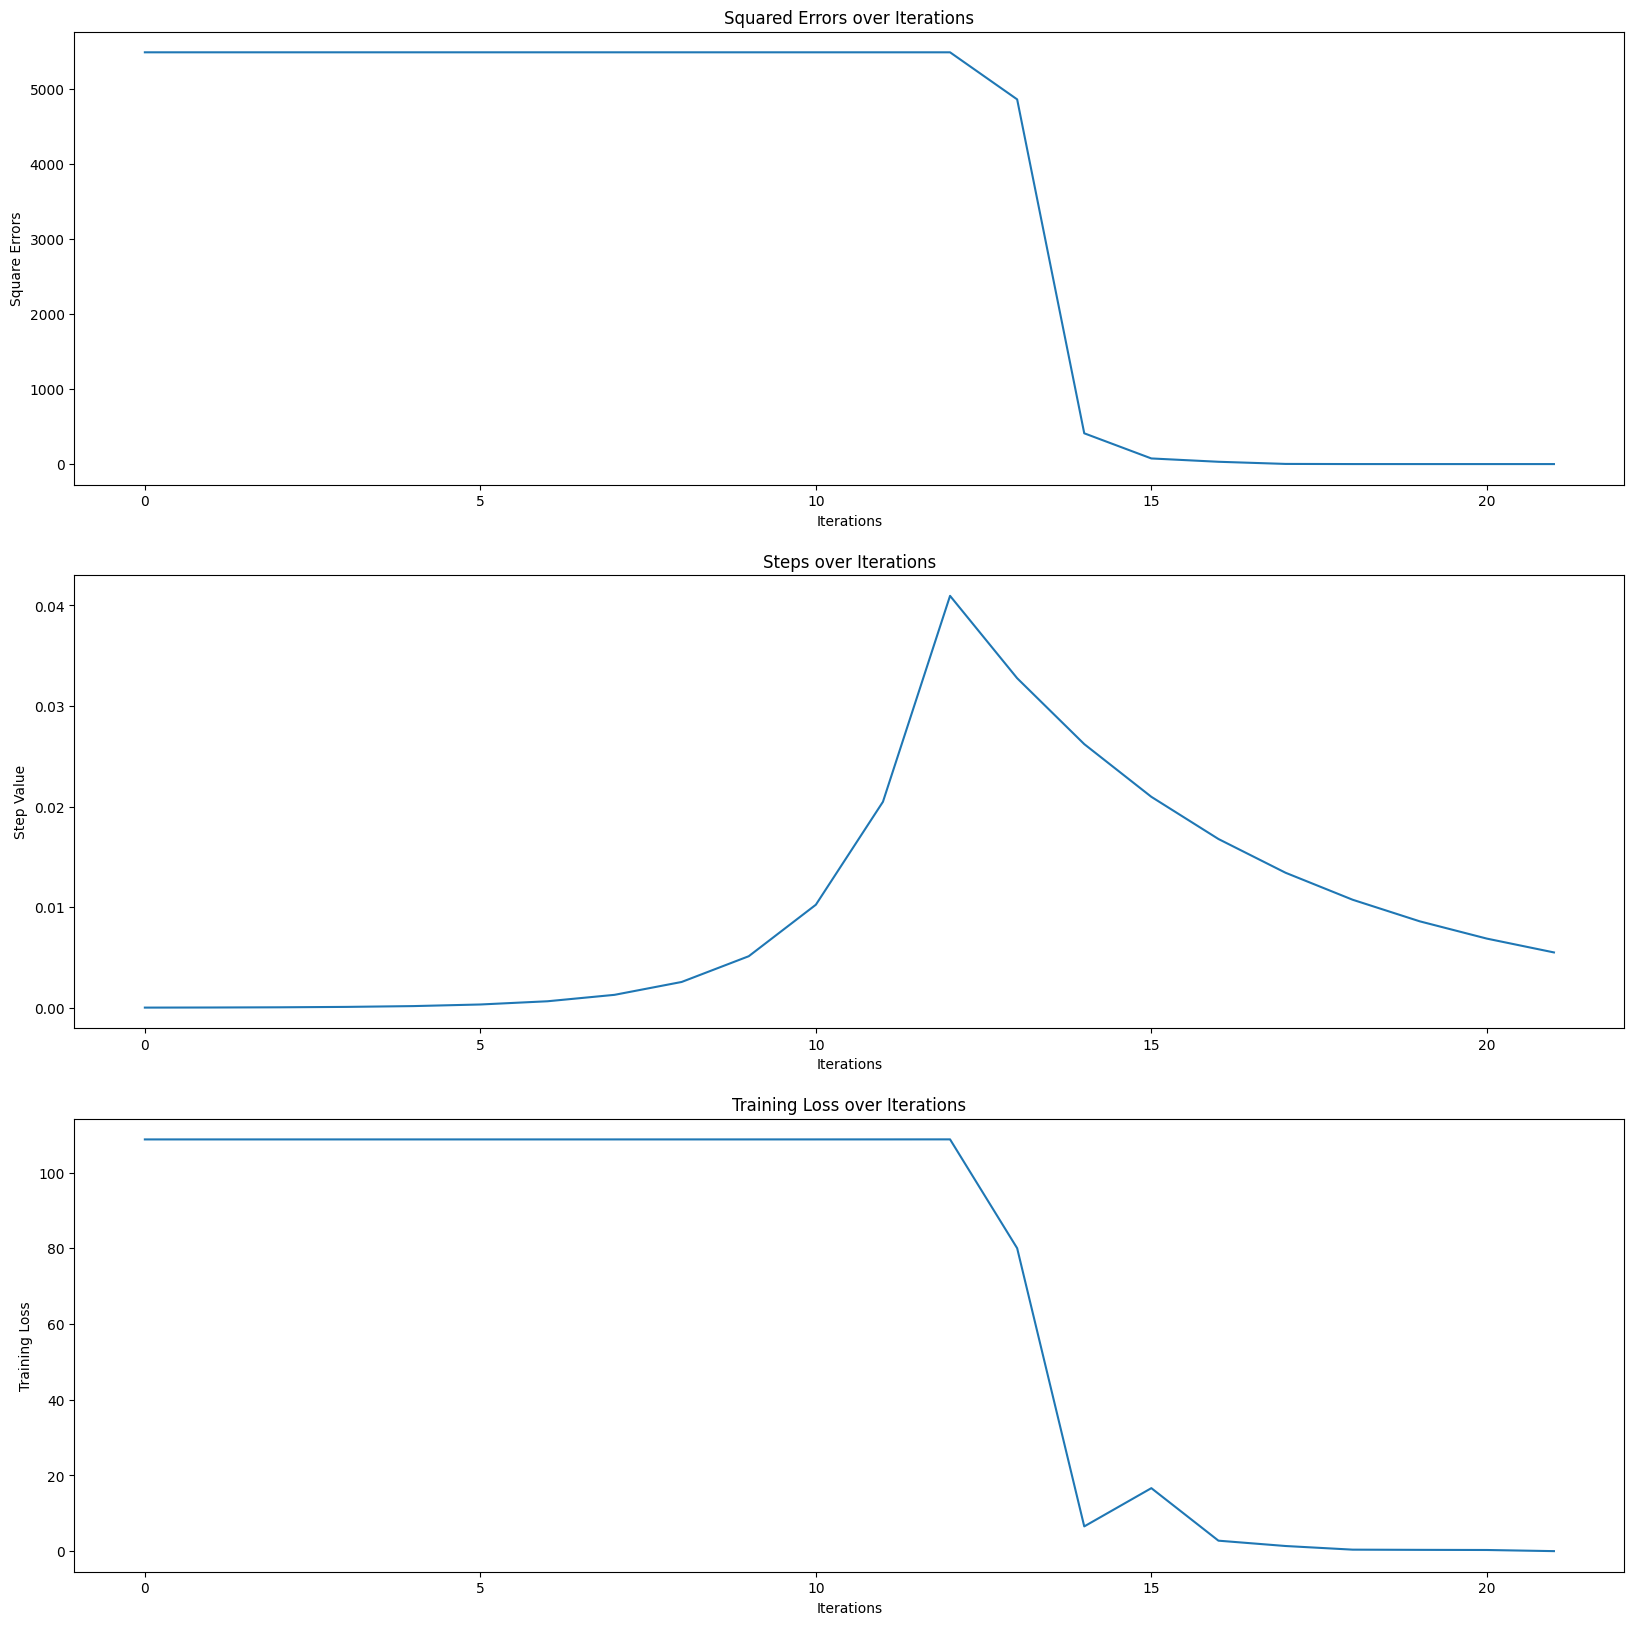

In [109]:
fig, arr = plt.subplots(3,1)
fig.set_size_inches(20, 20)
arr[0].plot(errs)
arr[0].set_title('Squared Errors over Iterations')
arr[0].set_xlabel('Iterations')
arr[0].set_ylabel('Square Errors')
arr[1].plot(steps)
arr[1].set_title('Steps over Iterations')
arr[1].set_xlabel('Iterations')
arr[1].set_ylabel('Step Value')
arr[2].plot(training_loss)
arr[2].set_title('Training Loss over Iterations')
arr[2].set_xlabel('Iterations')
arr[2].set_ylabel('Training Loss')

In [37]:
starts = []

# while np.linalg.norm(2*gradient.T@expected) < threshold:
while err > 0.000001:
    try:
        if err > 1000000 or len(errs) > 100:
            raise DivergenceException
        # this first part of the code will convert the program to a least squares problem

        # First find the gradient matrix
        gradient = gradient_matrix(data, weights)

        #Initialize a column vector with the expected values with the given weights
        expected = np.empty((0,))
        for x in data:
            expected = np.concatenate((expected, [f(x, weights)]), axis=0)

        # Find the value we are trying to project
        y = expected - gradient @ weights
        y = np.concatenate((y, -1*np.sqrt(step)*weights), axis=0)

        # Create the range space by appending the trust value to the gradient matrix
        A = np.concatenate((gradient, np.sqrt(step)*np.identity(gradient.shape[1])), axis=0)
        
        print(y.shape)
        print(A.shape)
        
        training_loss.append(np.linalg.norm(y-A@weights))
        # Solve least squares problem
        new_weights = np.linalg.pinv(A)@y

        # Calculate the error for newly create weights from solving least squares problem
        new_err = sum([np.square(f(data[i], new_weights) - y[i]) for i in range(len(data))])

        # Check if the new error is less than the previous error, otherwise, increase lamba
        if new_err < err:
            weights = new_weights
            err = new_err
            step = trust*step
        else:
            step = distrust*step

        # add step and error values to the list for plotting
        steps.append(step)
        errs.append(err)
    except KeyboardInterrupt:
        break
    except:
        print("Calculations Diverged")
        weights = np.random.normal(0,1, (16,))
        err = sum([np.square(f(x, weights)) for x in data])
        step = 0.00001
        steps = [step]
        errs = [err]
        training_loss = []
        # step = 1
        # steps.append(step)
        # errs.append(err)

# record training loss for last iteration
training_loss.append(np.linalg.norm(y-A@weights))

## Testing the Model on different $\Gamma$ and $\lambda$

The following code will attempt the Levenburg Marquadt Algorithm on varying values of $\Gamma$ which was the limiting value for the magnitudes of input values.

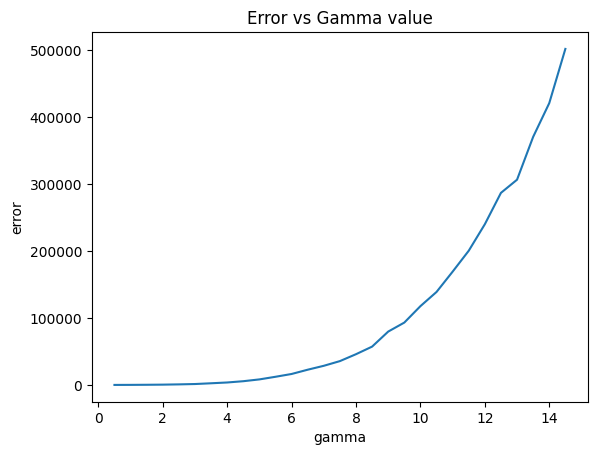

In [26]:
gammas = [i/2 for i in range(1, 30)]
avg_errs = []
for i in range(len(gammas)):
    errs = []
    for j in range(20):
        data_new, data_expected = generate_data_1(100, gammas[i])
        err = 0
        for k in range(len(data_new)):
            err += np.square(f(data_new[k], weights) - data_expected[k])
        errs.append(err)
    avg_errs.append(sum(errs)/len(errs))

fig, arr = plt.subplots(1)
arr.plot(gammas, avg_errs)
arr.set_title("Error vs Gamma value")
arr.set_xlabel('gamma')
arr.set_ylabel('error')

plt.show()

The following code will attempt the Levenburg Marquadt Algorithm on varying values of $\lambda$  which was the limiting value for the magnitudes of input values.

Text(0, 0.5, 'Number of Iterations')

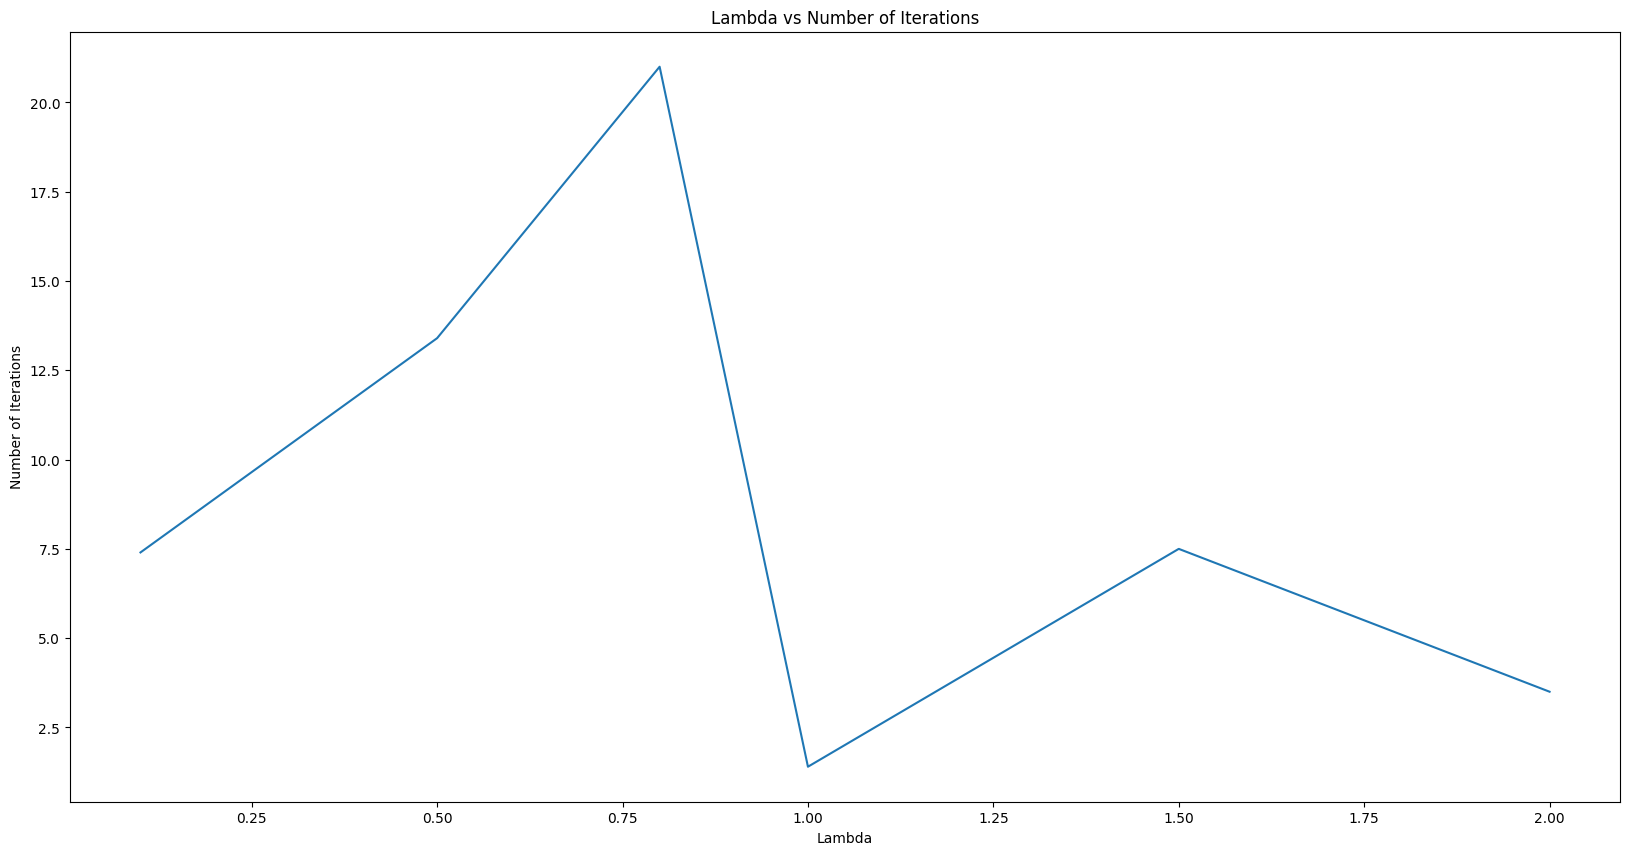

In [237]:
starts = [0.1, 0.5, 0.8, 1.0, 1.5, 2.0]
# fig, arr = plt.subplots(len(starts),2)
# fig.set_size_inches(20, 10)
fig, arr = plt.subplots(1)
fig.set_size_inches(20, 10)
avgs = []
for i in range(len(starts)):
    iterations = []
    for j in range(10):
        weights = np.random.normal(0,1, (16,))
        err = sum([np.square(f(x, weights)) for x in data])
        step = starts[i]
        steps = [step]
        errs = [err]
        # while np.linalg.norm(2*gradient.T@expected) < threshold:
        while err > 0.00001:
            try:
                if err > 1000000:
                    raise DivergenceException
                if len(errs) > 100:
                    steps = []
                    errs = []
                    break
                # convert to least squares
                gradient = gradient_matrix(data, weights)

                expected = np.empty((0,))
                for x in data:
                    expected = np.concatenate((expected, [f(x, weights)]), axis=0)

                y = expected - gradient @ weights


                y = np.concatenate((y, -1*np.sqrt(step)*weights), axis=0)
                A = np.concatenate((gradient, np.sqrt(step)*np.identity(gradient.shape[1])), axis=0)

                new_weights = np.linalg.pinv(A)@y
                new_err = sum([np.square(f(data[i], new_weights) - y[i]) for i in range(len(data))])
                if new_err < err:
                    weights = new_weights
                    err = new_err
                    step = trust*step
                else:
                    step = distrust*step
                steps.append(step)
                errs.append(err)
            except KeyboardInterrupt:
                break
            except:
                print("Calculations Diverged")
                weights = np.random.normal(0,1, (16,))
                err = sum([np.square(f(x, weights)) for x in data])
                step = starts[i]
                steps = [step]
                errs = [err]
                # step = 1
                # steps.append(step)
                # errs.append(err)
        iterations.append(len(errs))
        # arr[i][0].plot(errs)
        # arr[i][1].plot(steps)
    # arr[i][0].text(1, 9*max(errs)/10, str(sum(iterations)/len(iterations)), fontsize=10)
    avgs.append(sum(iterations)/len(iterations))
# arr[0][0].set_title('Errors over Gamma Values')
# arr[0][1].set_title('Steps over Gamma Values')
arr.plot(starts, avgs)
arr.set_title("Lambda vs Number of Iterations")
arr.set_xlabel('Lambda')
arr.set_ylabel('Number of Iterations')

## New Non-Linear Function: $[x]_1 - [x]_2[x]_3$

In [32]:
def generate_data_2(n, gamma):
    data = np.empty((0,3))
    out = np.empty((0,1))
    for i in range(n):
        x = np.random.uniform(-gamma, gamma, (3,))
        data = np.vstack((data,x))
        out = np.append(out,[x[0]-x[1]*x[2]])
    return data, out

In [33]:
# set up variables
data, expected = generate_data_2(500, 1)
weights = np.random.normal(0,1,(16,))

In [34]:
err = sum([np.square(f(x, weights)) for x in data])
step = 0.00001
trust = 0.8
distrust = 2
threshold = 0.01
steps = [step]
errs = [err]

In [36]:

# while np.linalg.norm(2*gradient.T@expected) < threshold:
while err > 0.00001:
    try:
        if err > 1000000:
            raise DivergenceException
        # convert to least squares
        gradient = gradient_matrix(data, weights)

        expected = np.empty((0,))
        for x in data:
            expected = np.concatenate((expected, [f(x, weights)]), axis=0)

        y = expected - gradient @ weights


        y = np.concatenate((y, -1*np.sqrt(step)*weights), axis=0)
        A = np.concatenate((gradient, np.sqrt(step)*np.identity(gradient.shape[1])), axis=0)

        new_weights = np.linalg.pinv(A)@y
        new_err = sum([np.square(f(data[i], new_weights) - y[i]) for i in range(len(data))])
        if new_err < err:
            weights = new_weights
            err = new_err
            step = trust*step
        else:
            step = distrust*step
        steps.append(step)
        errs.append(err)
    except KeyboardInterrupt:
        break
    except:
        print("Calculations Diverged")
        weights = np.random.normal(0,1, (16,))
        err = sum([np.square(f(x, weights)) for x in data])
        step = 0.00001
        steps = [step]
        errs = [err]
        # step = 1
        # steps.append(step)
        # errs.append(err)

/var/folders/lg/vx6rxtw54rn54kmbphrfhx180000gp/T/ipykernel_1127/1742935217.py:19: RuntimeWarning: invalid value encountered in multiply
  A = np.concatenate((gradient, np.sqrt(step)*np.identity(gradient.shape[1])), axis=0)


Calculations Diverged


Text(0.5, 1.0, 'Steps over Iterations')

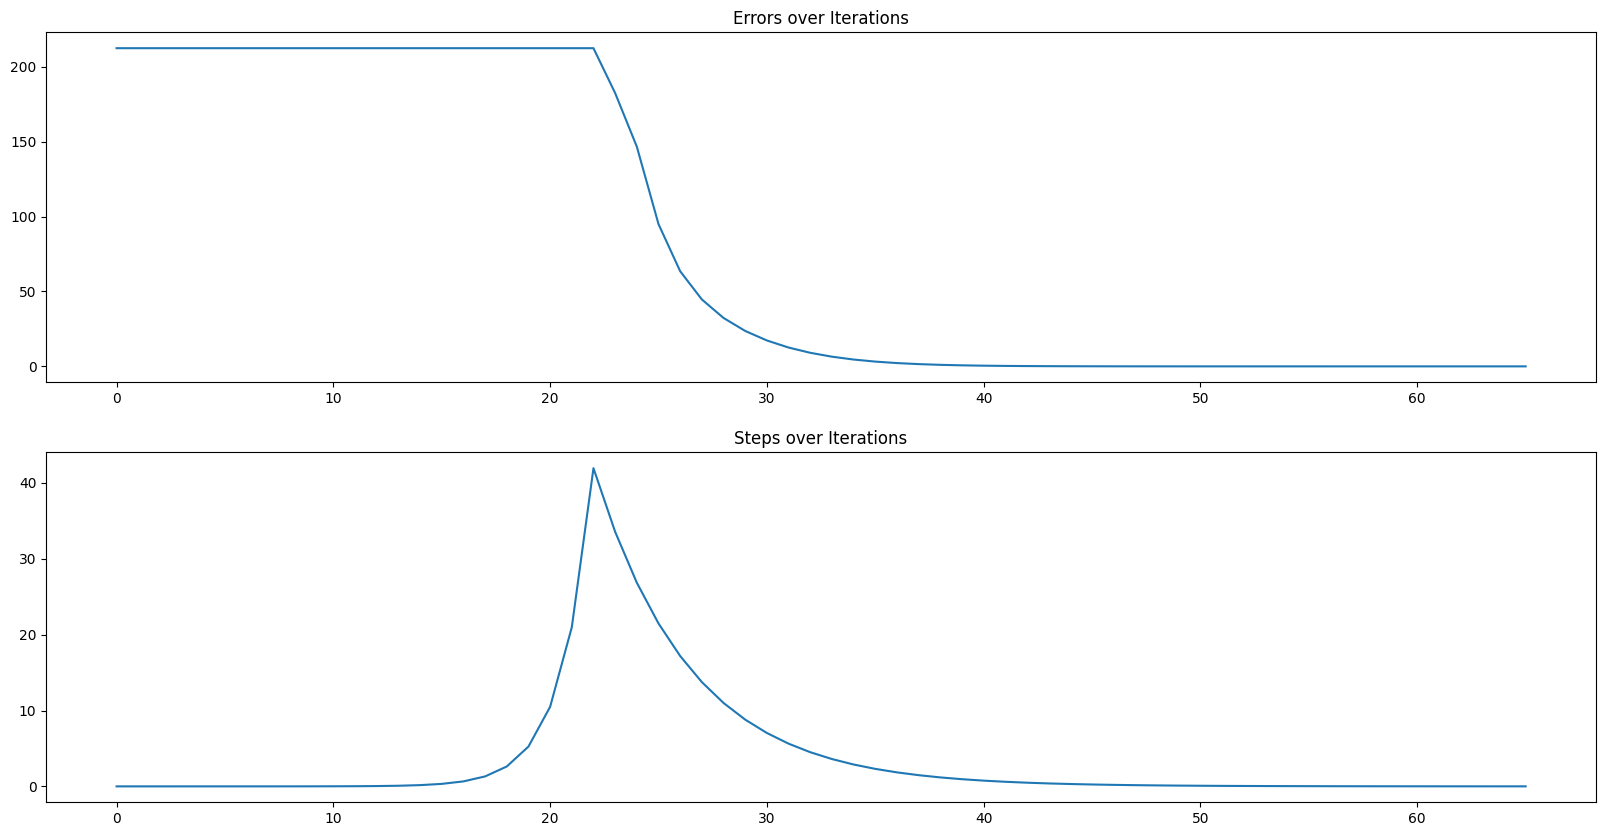

In [37]:
fig, arr = plt.subplots(2,1)
fig.set_size_inches(20, 10)
arr[0].plot(errs)
arr[0].set_title('Errors over Iterations')
arr[1].plot(steps)
arr[1].set_title('Steps over Iterations')

## Noisy Data Training

In [38]:
data, expected = generate_data_1(500, 1)
weights = np.random.normal(0,1,(16,))

In [39]:
err = sum([np.square(f(x, weights)) for x in data])
step = 0.00001
trust = 0.8
distrust = 2
threshold = 0.01
steps = [step]
errs = [err]

KeyboardInterrupt: 

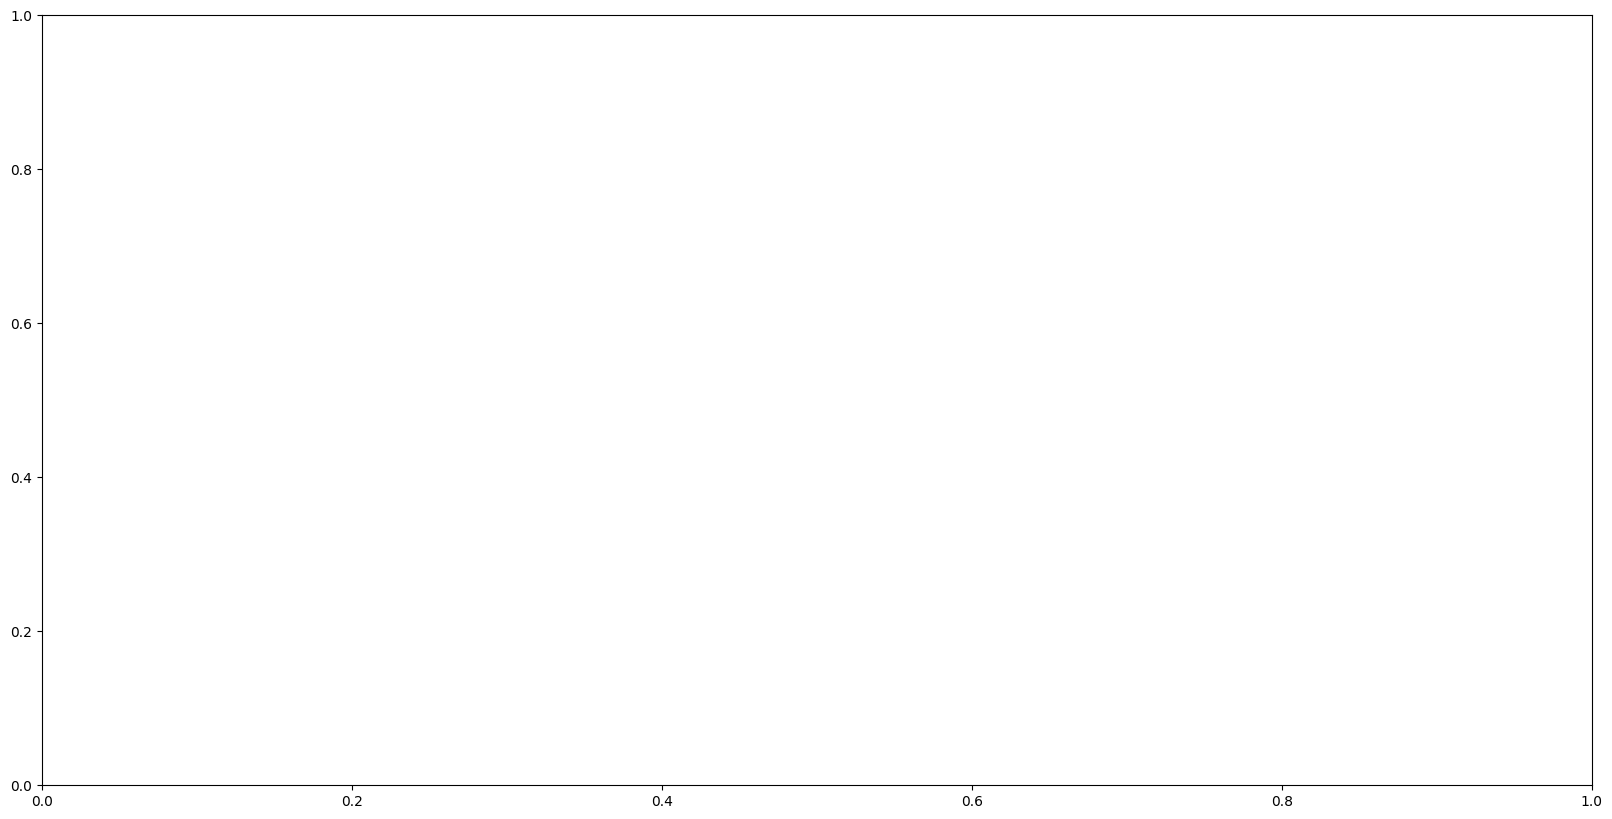

In [32]:
# add noise
norms = [0, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0]

fig, arr = plt.subplots(1)
fig.set_size_inches(20, 10)
avgs = []
for i in range(len(starts)):
    iterations = []
    for j in range(10):
        noise = np.random.normal(0,1, data.shape)
        data_noisy = data + noise * norms[i] / np.linalg.norm(noise)
        weights = np.random.normal(0,1, (16,))
        err = sum([np.square(f(x, weights)) for x in data_noisy])
        step = starts[i]
        steps = [step]
        errs = [err]
        # while np.linalg.norm(2*gradient.T@expected) < threshold:
        while err > 0.00001:
            try:
                if err > 1000000:
                    raise DivergenceException
                if len(errs) > 100:
                    steps = []
                    errs = []
                    break
                # convert to least squares
                gradient = gradient_matrix(data_noisy, weights)

                expected = np.empty((0,))
                for x in data_noisy:
                    expected = np.concatenate((expected, [f(x, weights)]), axis=0)

                y = expected - gradient @ weights
                
                y = np.concatenate((y, -1*np.sqrt(step)*weights), axis=0)
                A = np.concatenate((gradient, np.sqrt(step)*np.identity(gradient.shape[1])), axis=0)

                new_weights = np.linalg.pinv(A)@y
                new_err = sum([np.square(f(data[i], new_weights) - y[i]) for i in range(len(data_noisy))])
                if new_err < err:
                    weights = new_weights
                    err = new_err
                    step = trust*step
                else:
                    step = distrust*step
                steps.append(step)
                errs.append(err)
            except KeyboardInterrupt:
                break
            except:
                print("Calculations Diverged")
                weights = np.random.normal(0,1, (16,))
                err = sum([np.square(f(x, weights)) for x in data])
                step = starts[i]
                steps = [step]
                errs = [err]
                # step = 1
                # steps.append(step)
                # errs.append(err)
        iterations.append(len(errs))
        # arr[i][0].plot(errs)
        # arr[i][1].plot(steps)
    # arr[i][0].text(1, 9*max(errs)/10, str(sum(iterations)/len(iterations)), fontsize=10)
    avgs.append(sum(iterations)/len(iterations))
# arr[0][0].set_title('Errors over Gamma Values')
# arr[0][1].set_title('Steps over Gamma Values')
arr.plot(starts, avgs)

## Visualization 

Create a set of $\textbf{x}$ such that $[x]_1[x]_2+[x]_3=\rho$
Or in other words:
$$[x]_3=\rho - [x]_1[x]_2$$

In [319]:
rho = 0

The model will provide the following about $\textbf{x}$
$$ [x]_1[x]_2+[x]_3 = f_{\textbf{w}}(\textbf{x})$$
Since in most cases $f_{\textbf{w}}(\textbf{x}) \neq 0$, we can calculate how much residuals exist bectween $f_{\textbf{w}}(\textbf{x})$ and $\rho$ by solving for $[x]_3$ in the equation above. Initially, we know that $[x]_!$ and $[x]_2$ are consistently throughout every single equation.
Redefine the equation from provided by the model and solve for $[x]_3'$
$$ [x]_1[x]_2+[x]_3' = f_{\textbf{w}}(\textbf{x})$$
$$ [x]_3' = f_{\textbf{w}}(\textbf{x}) - [x]_1[x]_2$$


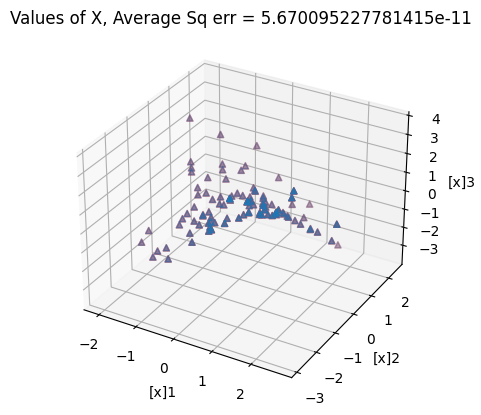

In [320]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

data = np.random.normal(0,1,(100,2))
data_expected = np.concatenate((data, np.reshape(rho-np.multiply(data[:,0],data[:,1]), (100,1))), axis=1)
# print(np.multiply(data_expected[:,0], data_expected[:,1])+data_expected[:,2])

x1 = data_expected[:,0]
y1 = data_expected[:,1]
z1 = data_expected[:,2]
ax.scatter(x1, y1, z1, marker="^")

# compute fw
data_predicted = np.empty((0,1))
for row in data_expected:
    data_predicted = np.vstack((data_predicted, f(row, basic_weights)))
x2 = data_expected[:,0]
y2 = data_expected[:,1]
z2 = data_expected[:,2] + data_predicted[:,0]

err = np.sum(np.square(z2 - z1))

ax.scatter(x2, y2, z2, marker="^", c='red')

ax.set_xlabel('[x]1')
ax.set_ylabel('[x]2')
ax.set_zlabel('[x]3')
ax.set_title('Values of X, Average Sq err = ' + str(err))
plt.show()